# 데이터 전처리

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip -qq '/content/gdrive/MyDrive/food-101.zip'

In [3]:
# imports
from fastai import *
from fastai.vision import *
from shutil import copyfile
import seaborn as sns

In [4]:
path = Path('/content/')
path_img = path/'images'
path_meta = path/'meta'

In [5]:
path_train = path/'data/train'

In [6]:
Path.mkdir(path/'data', exist_ok=True)

In [7]:
# load json of test filenames
test_json = open('/content/meta/meta/test.json', 'r')
test_json = json.load(test_json)
classes = list(test_json.keys())

In [8]:
classes[:10]

['churros',
 'hot_and_sour_soup',
 'samosa',
 'sashimi',
 'pork_chop',
 'spring_rolls',
 'panna_cotta',
 'beef_tartare',
 'greek_salad',
 'foie_gras']

In [9]:
# make test path
path_test = path/'data/test'
Path.mkdir(path_test, exist_ok=True)

In [10]:
# iterate over classes, copy test files over
# this creates a set of directories containing only test images
for clas in classes:
    Path.mkdir(path_test/clas, exist_ok=True)
    files = test_json[clas]
    
    for file in files:
        filename = file + '.jpg'
        copyfile(path_img/filename, path_test/filename)

In [11]:
# iterate over classes, copy test files over
# this creates a set of directories containing only test images
for clas in classes:
    Path.mkdir(path_test/clas, exist_ok=True)
    files = test_json[clas]
    
    for file in files:
        filename = file + '.jpg'
        copyfile(path_img/filename, path_test/filename)

In [12]:
# load train json
train_json = open('/content/meta/meta/train.json', 'r')
train_json = json.load(train_json)
classes = list(train_json.keys())

In [13]:
# make train path
path_train = path/'data/train'

In [14]:
Path.mkdir(path_train, exist_ok=True)

In [15]:
# copy train images to train directory
for clas in classes:
    Path.mkdir(path_train/clas, exist_ok=True)
    files = train_json[clas]
    
    for file in files:
        filename = file + '.jpg'
        copyfile(path_img/filename, path_train/filename)

In [16]:
path_data = path/'data'

In [17]:
raw_data = ImageList.from_folder(path/'data').split_by_folder(train='train', valid='test').label_from_folder(classes=None)

In [18]:
raw_data

LabelLists;

Train: LabelList (75750 items)
x: ImageList
Image (3, 512, 384),Image (3, 384, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 382)
y: CategoryList
prime_rib,prime_rib,prime_rib,prime_rib,prime_rib
Path: /content/data;

Valid: LabelList (25250 items)
x: ImageList
Image (3, 512, 512),Image (3, 355, 512),Image (3, 382, 512),Image (3, 306, 512),Image (3, 512, 512)
y: CategoryList
prime_rib,prime_rib,prime_rib,prime_rib,prime_rib
Path: /content/data;

Test: None

# 딥러닝

In [19]:

# batch size
bs = 96

In [20]:
# fast.ai transform functions
tfms = get_transforms(
                        do_flip=True,
                        flip_vert=True,
                        max_rotate=10.0,
                        max_zoom = 1.1,
                        max_lighting=0.25,
                        max_warp=0.25,
                        )

In [21]:
data = (ImageList.from_folder(path_train).split_by_rand_pct(0.07, seed=42)
                                       .label_from_folder(classes=None)
                                       .transform(tfms=tfms, size=256)
                                       .databunch(bs=bs, num_workers=6))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.

In [23]:
data

ImageDataBunch;

Train: LabelList (70448 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
prime_rib,prime_rib,prime_rib,prime_rib,prime_rib
Path: /content/data/train;

Valid: LabelList (5302 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
deviled_eggs,waffles,croque_madame,waffles,creme_brulee
Path: /content/data/train;

Test: None

In [24]:
# create learner object
# learner holds data, the model, the optimizer and other parameters for training
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
# apply mixup
learn = learn.mixup()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [25]:
learn.wd

0.01

In [26]:
learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=101, bias=True)
)

In [ ]:
learn.model

In [28]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [29]:
learn = learn.to_fp16(dynamic=True);
learn.freeze()

epoch,train_loss,valid_loss,error_rate,time


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


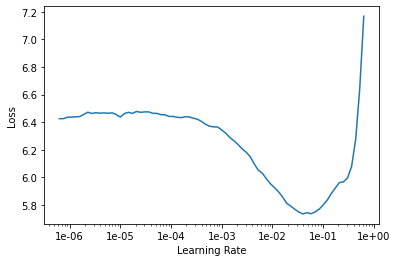

In [30]:
learn.lr_find()
learn.recorder.plot()